In [5]:
import os
import sklearn
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
import pickle
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import re
import xgboost as xgb
import lightgbm
from sklearn import ensemble
from sklearn import dummy
from sklearn import linear_model
from sklearn import svm
from sklearn import neural_network
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import scipy, gc
import argparse
from evaluate import load
from features_utils import supervised_learning_steps, save_model, load_model, calculate_classification_metrics
f1_metric,roc_metric,acc_metric,mcc_metric,prec_metric,rec_metric = load("f1"),load("roc_auc"),load("accuracy"),load("matthews_correlation"),load("precision"),load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return mcc_metric.compute(predictions=predictions, references=labels)

def full_compute_metrics(predictions,labels):
    #predictions = np.argmax(predictions, axis=1)
    return([f1_metric.compute(predictions=predictions, references=labels),\
            roc_metric.compute(prediction_scores=predictions, references=labels),\
            acc_metric.compute(predictions=predictions, references=labels),\
            mcc_metric.compute(predictions=predictions, references=labels),\
            prec_metric.compute(predictions=predictions, references=labels),\
            rec_metric.compute(predictions=predictions, references=labels)])

def get_CV_results (model, X_train, Y_train, n_splits):
    kf = KFold(n_splits=n_splits)
    f1_list, roc_list, acc_list, mcc_list, prec_list, rec_list = [],[],[],[],[],[]
    for train_index, test_index in kf.split(Y_train):
        y_pred = model.best_estimator_.predict(X_train.iloc[test_index,:])
        results=full_compute_metrics(y_pred,Y_train[test_index])
        print(results)
        f1_list.append(results[0]['f1'])
        roc_list.append(results[1]['roc_auc'])
        acc_list.append(results[2]['accuracy'])
        mcc_list.append(results[3]['matthews_correlation'])
        prec_list.append(results[4]['precision'])
        rec_list.append(results[5]['recall'])
    mean_f1, sd_f1 = round(np.mean(f1_list),3), round(np.std(f1_list),3)
    mean_roc, sd_roc = round(np.mean(roc_list),3), round(np.std(roc_list),3)
    mean_acc, sd_acc = round(np.mean(acc_list),3), round(np.std(acc_list),3)
    mean_mcc, sd_mcc = round(np.mean(mcc_list),3), round(np.std(mcc_list),3)
    mean_prec, sd_prec = round(np.mean(prec_list),3), round(np.std(prec_list),3)
    mean_rec, sd_rec = round(np.mean(rec_list),3), round(np.std(rec_list),3)
    return(mean_f1, sd_f1, mean_roc, sd_roc, mean_acc, sd_acc, mean_mcc, sd_mcc, mean_prec, sd_prec, mean_rec, sd_rec)


# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'floWith 47 new citations, your research items were the most cited research items from your institution last monthat16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':  # for integers
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # for floats.
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
#### read big train sample 
data = pd.read_csv("../..Data/big_train_sample.csv")
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
total_length = len(data.columns)
data['true_label'] = data['label'].replace({'positive': 1, 'negative': 0})
data

,Unnamed_0,allele,peptide,measurement_value,measurement_inequality,hla_sequence,category,Normalized_nM,label,peptide_id,...,boman_y,hydrophobicity_y,charge_y,molecular_weight_y,aliphatic_index_y,instability_index_y,structural_class_y,Locus,peptide_length,true_label
0,0,HLA-A*01:01,AAAALGRAP,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,0,...,0.001111,0.700000,0.997981,796.92474,98.888889,30.288889,alpha_beta,A,9,1
1,1,HLA-A*01:01,AAAGGGGGGGRY,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,1,...,0.254167,-0.266667,0.997131,949.97844,25.000000,64.583333,beta,A,12,1
2,2,HLA-A*01:01,AAAHTHRY,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,2,...,2.690000,-0.937500,1.178949,926.00244,37.500000,-20.712500,alpha,A,8,1
3,3,HLA-A*01:01,AADAVTGRTEEY,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,3,...,2.677500,-0.708333,-1.998873,1282.32944,49.166667,31.158333,alpha_beta,A,12,1
4,4,HLA-A*01:01,AADDYNRIGSSLY,100.0,<,YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY,positive,0.574375,positive,4,...,2.436923,-0.592308,-1.002827,1444.52044,75.384615,17.515385,alpha_beta,A,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661187,661187,HLA-C*17:01,YVINVTTHL,100.0,<,YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY,positive,0.574375,positive,50789,...,-0.148889,0.811111,0.088043,1059.23034,151.111111,-0.544444,alpha,C,9,1
661188,661188,HLA-C*17:01,YVQSMDVAAF,100.0,<,YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY,positive,0.574375,positive,141041,...,0.077000,0.760000,-1.002420,1130.28074,78.000000,52.940000,beta,C,10,1
661189,661189,HLA-C*17:01,YVVPYMIHL,100.0,<,YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY,positive,0.574375,positive,313300,...,-1.703333,1.244444,0.087193,1134.40164,151.111111,92.822222,alpha,C,9,1
661190,661190,HLA-C*17:01,YVVPYTIHL,100.0,<,YYAGYREKYRQADVNKLYIRYNFYSLAELAYEWY,positive,0.574375,positive,50809,...,-1.156667,0.955556,0.087193,1104.31414,151.111111,34.566667,beta,C,9,1


In [7]:
#Consider only those columns which have numeric values
print("Processing training data")
metadata_X, X_train, Y_train = data.loc[:,["Unnamed_0","allele","peptide","measurement_value","measurement_inequality","hla_sequence","category","Normalized_nM","peptide_id","Locus","peptide_length","label","allele_id"]], data.iloc[:,range(11,205)], data["true_label"].to_numpy().flatten()
print(X_train.columns)

#Get all numeric and categorical columns
print("Getting numerical and categorical features")
all_numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in all_numerical_cols]
print(numerical_features)

all_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in all_categorical_cols]
print("Identified categorical features")
print(categorical_features)

#Replace few rows with missing values with 0
X_train.loc[:,"N_terminal_Hydrophobicity"] = X_train.loc[:,"N_terminal_Hydrophobicity"].fillna(0)
X_train.loc[:,"C_terminal_Hydrophobicity"] = X_train.loc[:,"C_terminal_Hydrophobicity"].fillna(0)

# Setting up preprocessing steps
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
print("Setting up preprocessing steps...")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Perform preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
print("Pipeline Created.")

Processing training data
Index(['BLOSUM1_x', 'BLOSUM2_x', 'BLOSUM3_x', 'BLOSUM4_x', 'BLOSUM5_x',
       'BLOSUM6_x', 'BLOSUM7_x', 'BLOSUM8_x', 'BLOSUM9_x', 'BLOSUM10_x',
       ...
       'Z3_y', 'Z4_y', 'Z5_y', 'boman_y', 'hydrophobicity_y', 'charge_y',
       'molecular_weight_y', 'aliphatic_index_y', 'instability_index_y',
       'structural_class_y'],
      dtype='object', length=194)
Getting numerical and categorical features
['BLOSUM1_x', 'BLOSUM2_x', 'BLOSUM3_x', 'BLOSUM4_x', 'BLOSUM5_x', 'BLOSUM6_x', 'BLOSUM7_x', 'BLOSUM8_x', 'BLOSUM9_x', 'BLOSUM10_x', 'PP1_x', 'PP2_x', 'PP3_x', 'F1_x', 'F2_x', 'F3_x', 'F4_x', 'F5_x', 'F6_x', 'KF1_x', 'KF2_x', 'KF3_x', 'KF4_x', 'KF5_x', 'KF6_x', 'KF7_x', 'KF8_x', 'KF9_x', 'KF10_x', 'MSWHIM1_x', 'MSWHIM2_x', 'MSWHIM3_x', 'E1_x', 'E2_x', 'E3_x', 'E4_x', 'E5_x', 'PD1_x', 'PD2_x', 'ProtFP1_x', 'ProtFP2_x', 'ProtFP3_x', 'ProtFP4_x', 'ProtFP5_x', 'ProtFP6_x', 'ProtFP7_x', 'ProtFP8_x', 'SV1_x', 'SV2_x', 'SV3_x', 'SV4_x', 'ST1_x', 'ST2_x', 'ST3_x', 'ST

/tmp/ipykernel_7669/2840829814.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,"N_terminal_Hydrophobicity"] = X_train.loc[:,"N_terminal_Hydrophobicity"].fillna(0)
/tmp/ipykernel_7669/2840829814.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,"C_terminal_Hydrophobicity"] = X_train.loc[:,"C_terminal_Hydrophobicity"].fillna(0)


In [8]:
#Fitting the data
X_train_processed = pd.DataFrame(pipeline.fit_transform(X_train))
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1]\
                                    .named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(categorical_feature_names)
X_train_processed.columns = all_feature_names
print("Data processed")

#Keep only numeric training and test set and those which have no Nans
X_train_numerics_only = X_train_processed.select_dtypes(include=np.number)
print("Shape of training set after removing non-numeric cols")
print(X_train_numerics_only.shape)

#Remove columns with Nan values
nan_cols = [i for i in X_train_numerics_only.columns if X_train_numerics_only[i].isnull().any()]
column_names = X_train_numerics_only.columns.values.tolist()
print(nan_cols)

#Change floating points to reduce size of data
rev_X_train = X_train_numerics_only.drop(nan_cols,axis=1)
rev_X_train_o   = reduce_mem_usage(rev_X_train)
print("Shape of training set after removing cols with NaNs")
print(rev_X_train_o.shape)

del X_train
del X_train_processed
del X_train_numerics_only
del rev_X_train
gc.collect()

Data processed
Shape of training set after removing non-numeric cols
(661192, 239)
[]
Mem. usage decreased to 301.41 Mb (75.0% reduction)
Shape of training set after removing cols with NaNs
(661192, 239)


704

In [9]:
lgbm_gs = load_model("../../Models/lgbm_NC_binary_classifier_gs.pk")
results = get_CV_results(lgbm_gs,rev_X_train_o,Y_train,n_splits=5)
print(results)

Load model to file: ../Models/lgbm_models/lgbm_NC_binary_classifier_gs.pk
[{'f1': 0.849418715339405}, {'roc_auc': 0.8450560790935603}, {'accuracy': 0.8145857122331536}, {'matthews_correlation': 0.6435887717515425}, {'precision': 0.9580510646551127}, {'recall': 0.7629128698453324}]
[{'f1': 0.89865642314705}, {'roc_auc': 0.8937929547551113}, {'accuracy': 0.8701215223950575}, {'matthews_correlation': 0.7391627541425837}, {'precision': 0.9767200246267508}, {'recall': 0.8321476576074485}]
[{'f1': 0.9582156414731122}, {'roc_auc': 0.9040137756870402}, {'accuracy': 0.9297478788245436}, {'matthews_correlation': 0.7437518300340455}, {'precision': 0.9770776004402861}, {'recall': 0.9400681304716182}]
[{'f1': 0.962172474171865}, {'roc_auc': 0.9172755599331821}, {'accuracy': 0.9361227483779246}, {'matthews_correlation': 0.7637956396690604}, {'precision': 0.9817410852996545}, {'recall': 0.9433687223934596}]
[{'f1': 0.9779194210331934}, {'roc_auc': 0.9293959853896415}, {'accuracy': 0.9597619443730244}

In [10]:
lgbm_best = lgbm_gs.best_estimator_

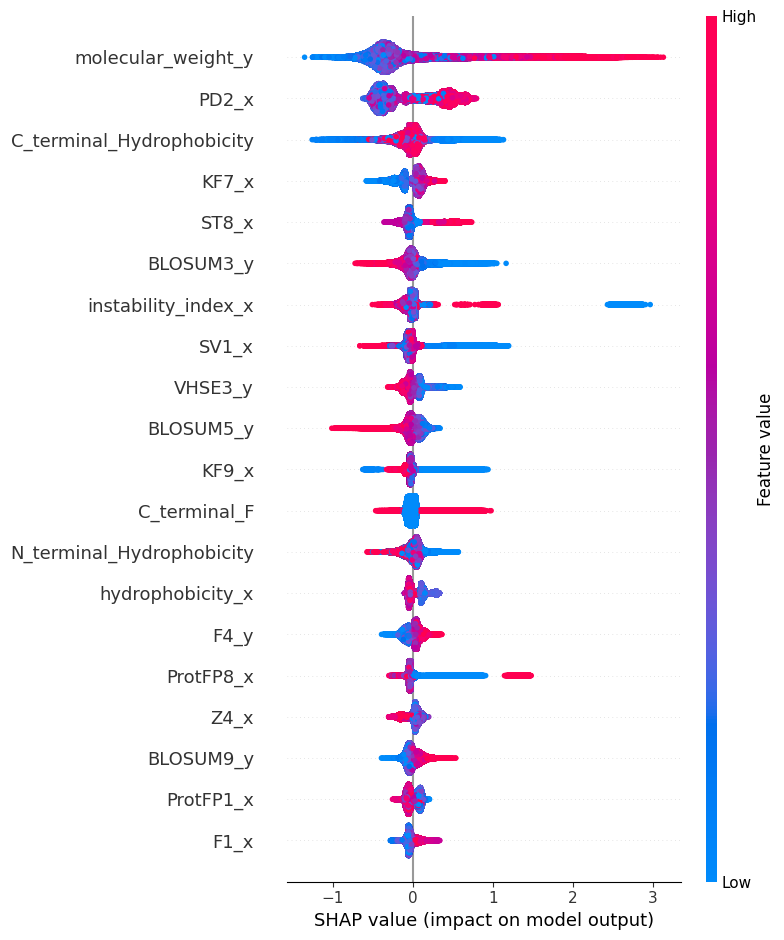

In [16]:
import matplotlib.pyplot as plt
import shap
explainer = shap.TreeExplainer(lgbm_best)
shap_values = explainer(rev_X_train_o)
shap.summary_plot(shap_values, rev_X_train_o, show=False)
plt.savefig("../../Figures/SHAP_feature_importance_plot.pdf", dpi=700)
